## Random Lake Environment

In [1]:
# HIDDEN
import numpy as np

In [2]:
# HIDDEN
import ray
import logging
ray.init(log_to_driver=False, ignore_reinit_error=True, logging_level=logging.ERROR); # logging.FATAL

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# HIDDEN

from ray.rllib.algorithms.ppo import PPOConfig

#### Learning a policy

- Let's train an agent to complete the Frozen Pond using RLlib.
- This is similar to our Frozen Lake agent from Module 1.

#### Quick aside: default config

- For brevity, we'll introduce the following default algorithm config settings:

In [4]:
lake_default_config = (
    PPOConfig()\
    .framework("torch")\
    .rollouts(create_env_on_local_worker=True, horizon=100)\
    .debugging(seed=0, log_level="ERROR")\
    .training(model={"fcnet_hiddens" : [32, 32]})
)

So, if you see `lake_default_config`, this is what it contains!

#### Learning a policy

- Back to it: let's train an agent to complete the Frozen Pond using RLlib.
- This is similar to our Frozen Lake agent from Module 1.

In [5]:
from gym.wrappers import TimeLimit
from envs import FrozenPond # defined in previous slides

In [6]:
ppo = lake_default_config.build(env=FrozenPond)

In [7]:
train_info = ppo.train()

#### Learning a policy

We see that the agent only reaches the goal in ~2% of evaluation episodes.

In [8]:
ppo.evaluate()["evaluation"]["episode_reward_mean"]

0.021897810218978103

We can improve the agent by training for more iterations.

#### Learning a policy

In [9]:
for i in range(8):
    ppo.train()

In [10]:
ppo.evaluate()["evaluation"]["episode_reward_mean"]

0.9612903225806452

With another 8 training iterations, we increased the success rate to more than 96%. Nice.

#### Beyond the simple environment

We just trained an agent to learn this fixed Frozen Pond:

In [11]:
pond = FrozenPond()
pond.reset()
pond.render()

🧑🧊🧊🧊
🧊🕳🧊🕳
🧊🧊🧊🕳
🕳🧊🧊⛳️


But this is quite an easy problem:

- Small state space
- Small action space
- No stochasticity

#### Random lake

- Let's make the problem harder by looking at a _random_ frozen lake
- That is, the hole locations change every episode.
- We'll do this by reimplementing the `reset` method:

In [12]:
class RandomLake(FrozenPond):
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.random.rand(4, 4) < 0.2
        self.holes[self.player] = 0  # no hole at start location
        self.holes[self.goal] = 0    # no hole at goal location
        
        return 0 # the observation corresponding to (0,0)

Now, each square (except the start and end locations) is a hole with probability 20%

#### Random lake

Here's one random lake:

In [13]:
# HIDDEN
np.random.seed(2)

In [14]:
lake = RandomLake()
lake.reset()
lake.render()

🧑🕳🧊🧊
🧊🧊🧊🧊
🧊🧊🧊🧊
🕳🧊🕳⛳️


Here's another:

In [15]:
# HIDDEN
np.random.seed(3)

In [16]:
lake.reset()
lake.render()

🧑🧊🧊🧊
🧊🧊🕳🧊
🕳🧊🕳🧊
🧊🧊🧊⛳️


#### Impossible games

And here's one more:

In [17]:
# HIDDEN
np.random.seed(1)

In [18]:
lake.reset()
lake.render()

🧑🧊🕳🧊
🕳🕳🕳🧊
🧊🧊🧊🧊
🧊🧊🕳⛳️


- This time, there is no way to the goal! 
- This is a situation where the maximum episode length would really come in handle.
  - We saw this earlier with the gym `TimeLimit` wrapper.
- With these impossible lakes, we should no longer be aiming for a 100% win rate.

#### Learning the random lake

- We've had success with RLlib so far, achieving a decent win rate on the original Frozen Lake.
- Let's try the random lake:

In [19]:
ppo = lake_default_config.build(env=RandomLake)

In [20]:
train_info = ppo.train()

In [21]:
ppo.evaluate()["evaluation"]["episode_reward_mean"]

0.15337423312883436

This looks good for only one training iteration.

#### Learning the random lake

Let's try more iterations:

In [22]:
for i in range(4):
    train_info = ppo.train()

In [23]:
ppo.evaluate()["evaluation"]["episode_reward_mean"]

0.35331230283911674

Yikes. Another 4 iterations?

In [24]:
for i in range(4):
    train_info = ppo.train()

In [25]:
ppo.evaluate()["evaluation"]["episode_reward_mean"]

0.328537170263789

It looks like we're hitting a plateau here and falling into the lake most of the time.

#### Comparing environments

Let's compare the learning curves of the two environments:

In [26]:
fixed_algo = lake_default_config.build(env=FrozenPond)
rando_algo = lake_default_config.build(env=RandomLake)
fixed_rewards = []
rando_rewards = []

for i in range(8):
    fixed_rewards.append(fixed_algo.train()['episode_reward_mean'])
    rando_rewards.append(rando_algo.train()['episode_reward_mean'])

#### Comparing environments

In [27]:
# HIDDEN

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

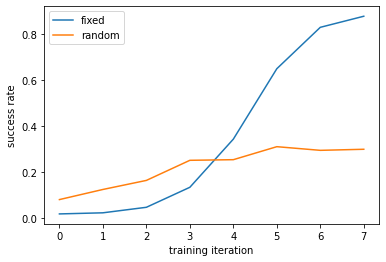

In [28]:
plt.plot(fixed_rewards, label="fixed")
plt.plot(rando_rewards, label="random")
plt.xlabel("training iteration")
plt.ylabel("success rate")
plt.legend();

This confirms our idea that the random lake environment is much harder to solve.

#### Random lake challenges

- So, why is the random lake so hard?
- Recall what we're learning: a policy, which maps observations to actions.
- Here, our observations are the location in the lake, and the action is the movement direction.
- So, say the observation is 3, meaning you're standing at the top-right. What action should you take?
- Answer: it depends on where the holes are!
- We're asking our agent to avoid holes _without being able to see_.
- In the next section we'll address this issue.

#### Let's apply what we learned!

In [ ]:
# HIDDEN
ppo.stop()
ray.shutdown()

## Number of holes
<!-- multiple choice -->

Our Random Lake environment is set up so that each square (except the start and goal) has a 20% probability of being a hole. 

#### Average episode reward

What do you think would happen to the average episode **reward** if we increased this number to 50%?

- [ ] The average episode reward would increase.
- [x] The average episode reward would decrease.

#### Average episode length

What do you think would happen to the average episode **length** if we increased this number to 50%?

- [ ] The average episode length would increase.
- [x] The average episode length would decrease.

## Where is the randomness?
<!-- multiple choice -->

In our implementation of `RandomLake`, we put the random hole creation in the `reset` method:

```python
self.holes = np.random.rand(4, 4) < 0.2
```

What would have happened if we put this in the constructor instead?

- [ ] It would behave the same as the current implementation.
- [ ] It would revert back to the non-random Frozen Pond from the previous module.
- [x] The holes would be randomized each time an environment is created, but all episodes would have the same random holes.

## Step counter
<!-- multiple choice -->

Let's say we wanted to implement a step counter in our environment _manually_, not using gym's `TimeLimit` wrapper or RLlib's `"horizon"` parameter for training. As a reminder, we would like the episodes to end after 50 steps even if you haven't reached the goal or fallen into a hole. 

#### Initializing the counter variable

First, we would need to created a new counter variable, say `self.stepcount`, and initialize it to zero with `self.stepcount = 0`. In which method would we include this code?

- [ ] constructor
- [x] `reset`
- [ ] `step`
- [ ] `done` (called by `step`)
- [ ] `render`

#### Incrementing the counter

Next, we would need to increment this counter after each step, say with `self.stepcount += 1`. In which method would we include this code?

- [ ] constructor
- [ ] `reset`
- [x] `step`
- [ ] `done` (called by `step`)
- [ ] `render`

#### Ending the episode

Finally, we would need to make sure the episode ends if the `self.stepcount >= 50`. Which method should we modify?

- [ ] constructor
- [ ] `reset`
- [ ] `step`
- [x] `done` (called by `step`)
- [ ] `render`

## Step counter: implementation
<!-- coding exercise -->

Below is the code of the Random Lake (minus rendering). Following the logic from the previous exercise, implement a step counter so that the max episode length is 50 steps. Then, test it out with the provided code, which repeatedly moves left (thus not moving at all).

In [30]:
# EXERCISE

import gym

class RandomLake(gym.Env):
    def __init__(self, env_config=None):
        self.observation_space = gym.spaces.Discrete(16)
        self.action_space = gym.spaces.Discrete(4)      
        
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.random.rand(4, 4) < 0.2
        self.holes[self.player] = 0  # no hole at start location
        self.holes[self.goal] = 0    # no hole at goal location
        
        self.stepcount = 0
        
        return self.observation()
    
    def observation(self):
        return 4*self.player[0] + self.player[1]
    
    def reward(self):
        return int(self.player == self.goal)
    
    def done(self):
        is_done = self.player == self.goal or self.holes[self.player] == 1 
        return is_done
    
    def is_valid_loc(self, location):
        return 0 <= location[0] <= 3 and 0 <= location[1] <= 3

    def step(self, action):
        # Compute the new player location
        if action == 0:   # left
            new_loc = (self.player[0], self.player[1]-1)
        elif action == 1: # down
            new_loc = (self.player[0]+1, self.player[1])
        elif action == 2: # right
            new_loc = (self.player[0], self.player[1]+1)
        elif action == 3: # up
            new_loc = (self.player[0]-1, self.player[1])
        else:
            raise ValueError("Action must be in {0,1,2,3}")
        
        # Update the player location only if you stayed in bounds
        if self.is_valid_loc(new_loc):
            self.player = new_loc
            
        self.stepcount += 1
        
        return self.observation(), self.reward(), self.done(), {}
    
lake = RandomLake()
obs = lake.reset()

done = False
for i in range(55):
    obs, rewards, done, _ = lake.step(0)
    print(i+1, done)

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False


In [31]:
# SOLUTION

import gym

class RandomLake(gym.Env):
    def __init__(self, env_config=None):
        self.observation_space = gym.spaces.Discrete(16)
        self.action_space = gym.spaces.Discrete(4)      
        
    def reset(self):
        self.player = (0, 0) # the player starts at the top-left
        self.goal = (3, 3)   # goal is at the bottom-right
        
        self.holes = np.random.rand(4, 4) < 0.2
        self.holes[self.player] = 0  # no hole at start location
        self.holes[self.goal] = 0    # no hole at goal location
        
        self.stepcount = 0
        
        return self.observation()
    
    def observation(self):
        return 4*self.player[0] + self.player[1]
    
    def reward(self):
        return int(self.player == self.goal)
    
    def done(self):
        is_done = self.player == self.goal or self.holes[self.player] == 1 or self.stepcount >= 50
        return is_done
    
    def is_valid_loc(self, location):
        return 0 <= location[0] <= 3 and 0 <= location[1] <= 3

    def step(self, action):
        # Compute the new player location
        if action == 0:   # left
            new_loc = (self.player[0], self.player[1]-1)
        elif action == 1: # down
            new_loc = (self.player[0]+1, self.player[1])
        elif action == 2: # right
            new_loc = (self.player[0], self.player[1]+1)
        elif action == 3: # up
            new_loc = (self.player[0]-1, self.player[1])
        else:
            raise ValueError("Action must be in {0,1,2,3}")
        
        # Update the player location only if you stayed in bounds
        if self.is_valid_loc(new_loc):
            self.player = new_loc
            
        self.stepcount += 1
        
        return self.observation(), self.reward(), self.done(), {}
    
lake = RandomLake()
obs = lake.reset()

done = False
for i in range(55):
    obs, rewards, done, _ = lake.step(0)
    print(i+1, done)

1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 True
51 True
52 True
53 True
54 True
55 True
